In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'
cluster_save_path = '../result/variable_cluster/rough&smooth'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}


In [14]:
# 构建训练集和测试集
import wshrRelabelLight as WRL

def datasetReconstruct(work_folder_path, work_folder_name, variable_list, isNormalized=False):
    # 获取给定mat的mechanism, control, external的变量作为X
    X, wshr_X = WRL.dataConstruct(work_folder_path, work_folder_name, variable_list, isNormalized)

    # 获取给定mat的ALTR对应判据数据作为train_Y
    ALT_diff_extend, ALTR_residual, ALTR_OOC_idx_list = WRL.ALTRmetrics(work_folder_path, work_folder_name)
    Y = np.array(ALT_diff_extend).reshape(-1,1)
    # Y = np.array([1 if abs(res) <= 500 else -1 for res in ALTR_residual]).reshape(-1,1)

    # # print(f"Altitute varying rate out of control at time: {ALTR_OOC_idx_list}")
    # plt.figure(figsize=(8, 8))
    # plt.plot(range(len(ALTR_residual)), ALTR_residual)
    # plt.axhline(y=500, color='r', linestyle='--', label='control limit = 500') 
    # plt.axhline(y=-500, color='r', linestyle='--', label='control limit = -500') 
    # plt.title(f'Residual of ALTR w.r.t ALT min-difference in {work_folder_name}')
    # plt.xlabel('time (s)')
    # plt.ylabel('Altitude varying rate residual')
    # plt.legend()
    # plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.plot(range(Y.shape[0]), Y)
    # plt.title(f'Label of ALTR w.r.t ALT min-difference in {work_folder_name}')
    # plt.xlabel('time (s)')
    # plt.ylabel('Altitude varying rate label')
    # plt.show()

    return X, Y

variable_list = []
for group_name, var_list in var_groups_dict.items():
    # if group_name in ["mechanism", "power", "control", "external"]:
    if group_name in ["mechanism", "control", "external"]:
        variable_list.extend(var_list)
# variable_list = ['ALTR', 'ALT']

train_folder_path = exception_folder_paths[3]
# train_folder_name = os.listdir(train_folder_path)[2]
train_X_list, train_Y_list = [], []
for train_mat_idx in [2]:
    train_mat_name = os.listdir(train_folder_path)[train_mat_idx]
    train_X_element, train_Y_element = datasetReconstruct(train_folder_path, train_mat_name, variable_list, isNormalized=True)
    train_X_list.append(train_X_element), train_Y_list.append(train_Y_element)

test_folder_path = exception_folder_paths[3]
test_folder_name = os.listdir(test_folder_path)[8]
test_X, test_Y = datasetReconstruct(test_folder_path, test_folder_name, variable_list, isNormalized=True)

In [40]:
# 使用LSTM进行训练
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, 1)

    def forward(self, lstm_output, last_hidden_state):
        seq_len = lstm_output.size(1)
        h_t = last_hidden_state
        print(lstm_output.size(), h_t.size())
        h_t = h_t.unsqueeze(0).repeat(seq_len, 1, 1)
        print(lstm_output.size(), h_t.size())
        attn_input = torch.cat([lstm_output, h_t], dim=2)
        attention_scores = self.attn(attn_input)
        attention_weights = F.softmax(attention_scores, dim=0)
        context_vector = torch.sum(attention_weights * lstm_output, dim=0)
        return context_vector, attention_weights

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.classify = nn.Sigmoid() # 用sigmoid做二分类比用tanh要好
 
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化隐藏状态
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # 初始化cell状态
 
        lstm_output, (last_hidden_state, _) = self.lstm(x, (h0, c0))  # LSTM层
        context_vector, attention_weights = self.attention(lstm_output, last_hidden_state) # attention层
        out = self.fc(context_vector) # 全连接层
        # out = self.fc(lstm_output[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        # out = self.classify(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 定义每个时间步的大小
step_size = 20 # 拉长时间步到1分钟作用不大

# 定义epoch大小
num_epochs = 1

# 参数初始化
input_size = train_X_list[0].shape[1] # 特征数
hidden_size = 50 # LSTM单元数量
num_layers = 4  # LSTM层数，层数越浅毛刺越多，层数越深越倾向于阶梯函数，目前看4层效果最好
output_size = 1  # 输出的维度
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 定义优化器

# 记录列表初始化
loss_list = []

# # test_Y标准化
# test_Y_scaled = StandardScaler().fit_transform(test_Y).reshape(-1, 1)

test_X_tensor, test_Y_tensor = torch.from_numpy(np.expand_dims(test_X, axis=0).astype(np.float32)), torch.from_numpy(test_Y.astype(np.float32))
test_X_tensor.to(device)
test_Y_tensor.to(device)
print(f"Test size: {test_X_tensor.size(), test_Y_tensor.size()}")

for iMat in range(len(train_X_list)):
    train_X, train_Y = train_X_list[iMat], train_Y_list[iMat]
    # 将array转化为torch张量
    train_X_tensor, train_Y_tensor = torch.from_numpy(np.expand_dims(train_X, axis=0).astype(np.float32)), torch.from_numpy(train_Y.astype(np.float32))
    train_X_tensor.to(device)
    train_Y_tensor.to(device)

    print(f"Train size in Batch {iMat+1}: {train_X_tensor.size(), train_Y_tensor.size()}")

    # 计算总的时间步数量
    num_steps = train_X_tensor.size(1) - step_size + 1

    # 定义batch大小
    batch_size = 4

    # 计算batch数量
    num_batches = num_steps // batch_size

    # 模型训练
    print(f"===== Training Batch {iMat+1} Start =====")
    for epoch in range(num_epochs):
        if (epoch+1) % 1 == 0:
            print(f'===== Epoch {epoch+1} Start =====')
        for step in tqdm(range(0, num_batches, batch_size)):
            # 提取batch_size大小和step_size步长的数据
            batch_X = torch.cat([train_X_tensor[:, step*iBatch:(step*iBatch+step_size), :] for iBatch in range(batch_size)], 0)
            batch_Y = torch.cat([train_Y_tensor[step*iBatch+step_size] for iBatch in range(batch_size)])
            output = model(batch_X)
            loss = criterion(torch.squeeze(output, dim=1), batch_Y)
            loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# 计算总的预测步长
num_steps = test_X_tensor.size(1) - step_size + 1

Y_pred = []
print("===== Testing Start =====")
for idel in range(step_size):
    Y_pred.append([0])
for epoch in tqdm(range(num_steps-1)):
    y_pred = model(test_X_tensor[:, epoch:(epoch+step_size), :])
    Y_pred.append(y_pred.tolist()[0])
Y_pred_tensor = torch.from_numpy(np.array(Y_pred))
# print(Y_pred_tensor.size(), test_Y_tensor.size())
mse = criterion(Y_pred_tensor, test_Y_tensor)

# # 将预测值拉伸到0,1范围
# Y_pred_scaled = StandardScaler().fit_transform(Y_pred)

# 可视化预测形状
plt.figure()
plt.plot(Y_pred, c='orange', label='Predicted')
plt.title('ALTR residual -- Predicted')
plt.legend()
plt.show()

# 打印模型性能
print("模型性能：", mse)
plt.figure()
plt.plot(test_Y, c='b', label='Actual')
plt.plot(Y_pred, c='orange', label='Predicted')
plt.title('ALTR residual -- Predicted vs Actual')
plt.legend()
plt.show()

# 可视化损失值的变化
plt.figure()
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

cuda
Test size: (torch.Size([1, 8656, 90]), torch.Size([8656, 1]))
Train size in Batch 1: (torch.Size([1, 7852, 90]), torch.Size([7852, 1]))
===== Training Batch 1 Start =====
===== Epoch 1 Start =====


  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

torch.Size([4, 20, 50]) torch.Size([4, 4, 50])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [37]:
print(range(0, 10, 2))

range(0, 10, 2)


In [33]:
step = 0
batch_size = 4
tmp = torch.cat([train_Y_tensor[step*iBatch+step_size] for iBatch in range(batch_size)])
print(tmp.size())

torch.Size([4])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, 1)

    def forward(self, lstm_output, last_hidden_state):
        seq_len = lstm_output.size(0)
        h_t = last_hidden_state
        h_t = h_t.unsqueeze(0).repeat(seq_len, 1, 1)
        attn_input = torch.cat([lstm_output, h_t], dim=2)
        attention_scores = self.attn(attn_input)
        attention_weights = F.softmax(attention_scores, dim=0)
        context_vector = torch.sum(attention_weights * lstm_output, dim=0)
        return context_vector, attention_weights

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_output, (last_hidden_state, _) = self.lstm(input_seq)
        print(last_hidden_state.size())
        context_vector, attention_weights = self.attention(lstm_output, last_hidden_state)
        output = self.fc(context_vector)
        return output, attention_weights

# 创建一个示例的输入序列
input_seq = torch.randn(10, 5, 10)  # (sequence_length, batch_size, input_size)

# 创建一个带有注意力机制的LSTM模型
lstm_model = LSTMWithAttention(input_size=10, hidden_size=20, output_size=1)

# 使用模型进行前向传播
output, attention_weights = lstm_model(input_seq)

# 打印输出和注意力权重
print("模型输出：", output)
print("注意力权重：", attention_weights)


torch.Size([1, 10, 20])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

===== Batch 100 Training =====
===== Batch 200 Training =====
===== Batch 300 Training =====
===== Batch 400 Training =====
test complete
evaluate complete


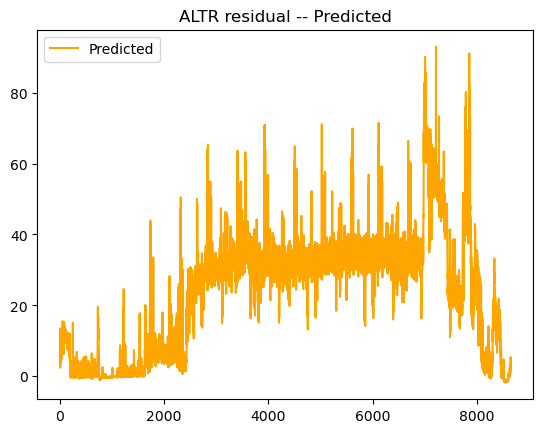

模型性能： 0.015042529695185491


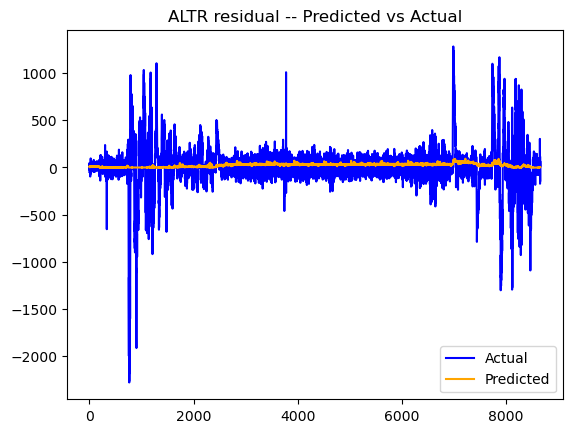

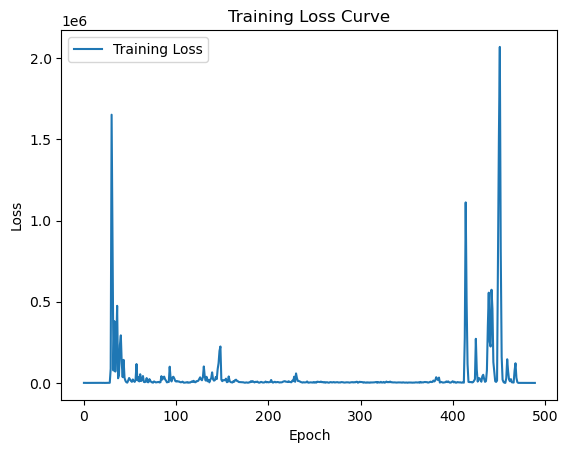

In [79]:
# 使用mlp进行训练
'''
还是要考虑时序模型
'''
# 构建MLP
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# 定义每个batch的大小
batch_size = 16

def mlpFit(train_X, train_Y, test_X, test_Y):    
    # 创建权重记录列表
    weights_record_list = []

    # 计算总的batch数量
    num_batches = train_X.shape[0] // batch_size

    # # 随机打乱数据集的索引
    # indices = np.random.permutation(train_X.shape[1])
    indices = np.arange(train_X.shape[0])

    # 创建MLP回归器实例
    mlp = MLPRegressor(hidden_layer_sizes = (50, 100, 50), activation='relu', solver='adam', random_state = 42, max_iter=500, learning_rate='invscaling', learning_rate_init=0.001, verbose=False)
    # mlp_list = []

    # 按照每个batch逐批训练
    for i in tqdm(range(num_batches)):
        # if (i + 1) % 100 == 0:
        #     print(f'===== Batch {i+1} Training =====')
        # 获取当前batch的索引
        batch_indices = indices[i * batch_size: (i + 1) * batch_size]

        # 获取当前batch的数据
        batch_X = train_X[batch_indices]
        batch_Y = train_Y[batch_indices]

        # 逐批训练模型
        mlp.partial_fit(batch_X, batch_Y.ravel())
        loss_values = mlp.loss_curve_
        # print(f"train complete in batch {i}")

        # 调用回调函数
        weights = mlp.coefs_
        weights_record_list.append(weights)

    # 测试模型
    y_pred = mlp.predict(test_X)
    # for i in range(y_pred.shape[1]):
    #     plt.figure()
    #     plt.plot(y_pred[:,i], label='Predicted')
    #     plt.plot(test_Y[:,i], label='Actual')
    #     plt.show()
    print("test complete")

    # 评估模型的性能
    accuracy = mlp.score(test_X, test_Y)
    print("evaluate complete")

    # # 打印模型性能
    # print("模型性能：", mlp.score(train_X, train_Y))
    # plt.figure()
    # plt.plot(train_Y, c='b', label='Actual')
    # plt.plot(mlp.predict(train_X), c='orange', label='Predicted')
    # plt.title('ALTR residual -- Predicted vs Actual')
    # plt.legend()
    # plt.show()

    # 可视化预测形状
    plt.figure()
    plt.plot(y_pred, c='orange', label='Predicted')
    plt.title('ALTR residual -- Predicted')
    plt.legend()
    plt.show()

    # 打印模型性能
    print("模型性能：", accuracy)
    plt.figure()
    plt.plot(test_Y, c='b', label='Actual')
    plt.plot(y_pred, c='orange', label='Predicted')
    plt.title('ALTR residual -- Predicted vs Actual')
    plt.legend()
    plt.show()

    # 可视化损失值的变化
    plt.figure()
    plt.plot(loss_values, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return weights_record_list

# 拟合模型
weights_record_list = mlpFit(train_X, train_Y, test_X, test_Y)